In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [7]:
    train_dir = 'data/kaggle_histo/train/'
test_dir = "data/kaggle_histo/test/"

extracted_features_dir = "extracted_features/"
model_name = "kaggle_ReSNet50"

In [8]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [9]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [10]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/kaggle_histo/train/ 0
data/kaggle_histo/train/cancer 256400
data/kaggle_histo/train/normal 375900
******************************
data/kaggle_histo/test/ 0
data/kaggle_histo/test/cancer 6368
data/kaggle_histo/test/normal 9376


In [11]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 474225 images belonging to 2 classes.
Found 158075 images belonging to 2 classes.
Found 15744 images belonging to 2 classes.


In [12]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 474225
nb_validation_samples: 158075

predict_size_train: 14820
predict_size_validation: 4940
nb_test_samples: 15744
predict_size_test: 492

 num_classes: 2


In [13]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [15]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [16]:
input_tensor = Input(shape = input_shape)  
model = ResNet50(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [17]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [18]:
# c1 = model.layers[4].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[7].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[12].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[17].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [19]:
# bottleneck_final_model.summary()

In [20]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [21]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [22]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [23]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 474225 samples, validate on 158075 samples
Epoch 1/1000
 - 51s - loss: 0.5196 - acc: 0.7451 - val_loss: 0.4885 - val_acc: 0.7695
Epoch 2/1000
 - 49s - loss: 0.4951 - acc: 0.7639 - val_loss: 0.4787 - val_acc: 0.7732
Epoch 3/1000
 - 49s - loss: 0.4906 - acc: 0.7681 - val_loss: 0.4800 - val_acc: 0.7726
Epoch 4/1000
 - 49s - loss: 0.4880 - acc: 0.7702 - val_loss: 0.4759 - val_acc: 0.7733
Epoch 5/1000
 - 49s - loss: 0.4866 - acc: 0.7720 - val_loss: 0.4787 - val_acc: 0.7756
Epoch 6/1000
 - 49s - loss: 0.4851 - acc: 0.7730 - val_loss: 0.4735 - val_acc: 0.7804
Epoch 7/1000
 - 49s - loss: 0.4851 - acc: 0.7738 - val_loss: 0.4733 - val_acc: 0.7775
Epoch 8/1000
 - 49s - loss: 0.4842 - acc: 0.7751 - val_loss: 0.4809 - val_acc: 0.7796
Epoch 9/1000
 - 49s - loss: 0.4835 - acc: 0.7759 - val_loss: 0.4714 - val_acc: 0.7840
Epoch 10/1000
 - 49s - loss: 0.4831 - acc: 0.7771 - val_loss: 0.4729 - val_acc: 0.7843
Epoch 11/1000
 - 49s - loss: 0.4834 - acc: 0.7769 - val_loss: 0.4710 - val_acc: 0.7822


Epoch 95/1000
 - 49s - loss: 0.4852 - acc: 0.7838 - val_loss: 0.4728 - val_acc: 0.7884
Epoch 96/1000
 - 49s - loss: 0.4856 - acc: 0.7838 - val_loss: 0.4725 - val_acc: 0.7883
Epoch 97/1000
 - 49s - loss: 0.4854 - acc: 0.7843 - val_loss: 0.4699 - val_acc: 0.7895
Epoch 98/1000
 - 49s - loss: 0.4860 - acc: 0.7838 - val_loss: 0.4734 - val_acc: 0.7893
Epoch 99/1000
 - 49s - loss: 0.4857 - acc: 0.7840 - val_loss: 0.4779 - val_acc: 0.7825
Epoch 100/1000
 - 49s - loss: 0.4859 - acc: 0.7842 - val_loss: 0.4772 - val_acc: 0.7897
Epoch 101/1000
 - 49s - loss: 0.4859 - acc: 0.7843 - val_loss: 0.4735 - val_acc: 0.7845
Epoch 102/1000
 - 49s - loss: 0.4852 - acc: 0.7845 - val_loss: 0.4759 - val_acc: 0.7896
Epoch 103/1000
 - 49s - loss: 0.4850 - acc: 0.7841 - val_loss: 0.4752 - val_acc: 0.7890
Epoch 104/1000
 - 49s - loss: 0.4855 - acc: 0.7841 - val_loss: 0.4808 - val_acc: 0.7887
Epoch 105/1000
 - 49s - loss: 0.4863 - acc: 0.7843 - val_loss: 0.4797 - val_acc: 0.7845
Epoch 106/1000
 - 49s - loss: 0.4857 

 - 49s - loss: 0.4824 - acc: 0.7851 - val_loss: 0.4698 - val_acc: 0.7904
Epoch 189/1000
 - 49s - loss: 0.4824 - acc: 0.7851 - val_loss: 0.4657 - val_acc: 0.7897
Epoch 190/1000
 - 49s - loss: 0.4820 - acc: 0.7850 - val_loss: 0.4697 - val_acc: 0.7894
Epoch 191/1000
 - 49s - loss: 0.4818 - acc: 0.7848 - val_loss: 0.4712 - val_acc: 0.7869
Epoch 192/1000
 - 49s - loss: 0.4824 - acc: 0.7854 - val_loss: 0.4702 - val_acc: 0.7891
Epoch 193/1000
 - 49s - loss: 0.4830 - acc: 0.7848 - val_loss: 0.4681 - val_acc: 0.7898
Epoch 194/1000
 - 49s - loss: 0.4818 - acc: 0.7852 - val_loss: 0.4685 - val_acc: 0.7878
Epoch 195/1000
 - 49s - loss: 0.4818 - acc: 0.7850 - val_loss: 0.4758 - val_acc: 0.7883
Epoch 196/1000
 - 49s - loss: 0.4812 - acc: 0.7851 - val_loss: 0.4724 - val_acc: 0.7892
Epoch 197/1000
 - 49s - loss: 0.4810 - acc: 0.7852 - val_loss: 0.4668 - val_acc: 0.7886
Epoch 198/1000
 - 49s - loss: 0.4804 - acc: 0.7848 - val_loss: 0.4670 - val_acc: 0.7884
Epoch 199/1000
 - 49s - loss: 0.4801 - acc: 0.7

Epoch 282/1000
 - 49s - loss: 0.4749 - acc: 0.7861 - val_loss: 0.4610 - val_acc: 0.7904
Epoch 283/1000
 - 49s - loss: 0.4750 - acc: 0.7859 - val_loss: 0.4622 - val_acc: 0.7900
Epoch 284/1000
 - 49s - loss: 0.4753 - acc: 0.7857 - val_loss: 0.4636 - val_acc: 0.7900
Epoch 285/1000
 - 49s - loss: 0.4754 - acc: 0.7856 - val_loss: 0.4626 - val_acc: 0.7909
Epoch 286/1000
 - 49s - loss: 0.4750 - acc: 0.7857 - val_loss: 0.4645 - val_acc: 0.7895
Epoch 287/1000
 - 49s - loss: 0.4750 - acc: 0.7856 - val_loss: 0.4632 - val_acc: 0.7894
Epoch 288/1000
 - 49s - loss: 0.4747 - acc: 0.7856 - val_loss: 0.4639 - val_acc: 0.7896
Epoch 289/1000
 - 49s - loss: 0.4754 - acc: 0.7856 - val_loss: 0.4623 - val_acc: 0.7904
Epoch 290/1000
 - 49s - loss: 0.4751 - acc: 0.7852 - val_loss: 0.4617 - val_acc: 0.7899
Epoch 291/1000
 - 50s - loss: 0.4745 - acc: 0.7859 - val_loss: 0.4632 - val_acc: 0.7904
Epoch 292/1000
 - 49s - loss: 0.4751 - acc: 0.7857 - val_loss: 0.4626 - val_acc: 0.7900
Epoch 293/1000
 - 49s - loss: 0.

 - 49s - loss: 0.4753 - acc: 0.7859 - val_loss: 0.4639 - val_acc: 0.7895
Epoch 376/1000
 - 49s - loss: 0.4752 - acc: 0.7865 - val_loss: 0.4616 - val_acc: 0.7899
Epoch 377/1000
 - 49s - loss: 0.4754 - acc: 0.7864 - val_loss: 0.4614 - val_acc: 0.7895
Epoch 378/1000
 - 49s - loss: 0.4750 - acc: 0.7859 - val_loss: 0.4632 - val_acc: 0.7898
Epoch 379/1000
 - 49s - loss: 0.4752 - acc: 0.7859 - val_loss: 0.4616 - val_acc: 0.7904
Epoch 380/1000
 - 49s - loss: 0.4752 - acc: 0.7861 - val_loss: 0.4624 - val_acc: 0.7904
Epoch 381/1000
 - 49s - loss: 0.4755 - acc: 0.7863 - val_loss: 0.4646 - val_acc: 0.7898
Epoch 382/1000
 - 49s - loss: 0.4744 - acc: 0.7859 - val_loss: 0.4632 - val_acc: 0.7898
Epoch 383/1000
 - 49s - loss: 0.4752 - acc: 0.7862 - val_loss: 0.4638 - val_acc: 0.7915
Epoch 384/1000
 - 49s - loss: 0.4749 - acc: 0.7862 - val_loss: 0.4633 - val_acc: 0.7908
Epoch 385/1000
 - 49s - loss: 0.4751 - acc: 0.7861 - val_loss: 0.4627 - val_acc: 0.7897
Epoch 386/1000
 - 49s - loss: 0.4748 - acc: 0.7

Epoch 469/1000
 - 49s - loss: 0.4741 - acc: 0.7865 - val_loss: 0.4641 - val_acc: 0.7900
Epoch 470/1000
 - 49s - loss: 0.4748 - acc: 0.7862 - val_loss: 0.4607 - val_acc: 0.7907
Epoch 471/1000
 - 49s - loss: 0.4750 - acc: 0.7865 - val_loss: 0.4619 - val_acc: 0.7905
Epoch 472/1000
 - 49s - loss: 0.4741 - acc: 0.7863 - val_loss: 0.4610 - val_acc: 0.7904
Epoch 473/1000
 - 49s - loss: 0.4747 - acc: 0.7869 - val_loss: 0.4640 - val_acc: 0.7907
Epoch 474/1000
 - 49s - loss: 0.4744 - acc: 0.7870 - val_loss: 0.4618 - val_acc: 0.7915
Epoch 475/1000
 - 49s - loss: 0.4737 - acc: 0.7869 - val_loss: 0.4603 - val_acc: 0.7912
Epoch 476/1000
 - 49s - loss: 0.4742 - acc: 0.7866 - val_loss: 0.4611 - val_acc: 0.7902
Epoch 477/1000
 - 49s - loss: 0.4747 - acc: 0.7867 - val_loss: 0.4619 - val_acc: 0.7903
Epoch 478/1000
 - 49s - loss: 0.4742 - acc: 0.7869 - val_loss: 0.4642 - val_acc: 0.7912
Epoch 479/1000
 - 49s - loss: 0.4741 - acc: 0.7873 - val_loss: 0.4601 - val_acc: 0.7909
Epoch 480/1000
 - 49s - loss: 0.

 - 49s - loss: 0.4744 - acc: 0.7867 - val_loss: 0.4599 - val_acc: 0.7906
Epoch 563/1000
 - 49s - loss: 0.4746 - acc: 0.7864 - val_loss: 0.4607 - val_acc: 0.7913
Epoch 564/1000
 - 49s - loss: 0.4742 - acc: 0.7867 - val_loss: 0.4621 - val_acc: 0.7912
Epoch 565/1000
 - 49s - loss: 0.4738 - acc: 0.7873 - val_loss: 0.4617 - val_acc: 0.7903
Epoch 566/1000
 - 49s - loss: 0.4739 - acc: 0.7870 - val_loss: 0.4607 - val_acc: 0.7911
Epoch 567/1000
 - 49s - loss: 0.4741 - acc: 0.7870 - val_loss: 0.4606 - val_acc: 0.7910
Epoch 568/1000
 - 49s - loss: 0.4735 - acc: 0.7869 - val_loss: 0.4617 - val_acc: 0.7908
Epoch 569/1000
 - 49s - loss: 0.4735 - acc: 0.7873 - val_loss: 0.4599 - val_acc: 0.7913
Epoch 570/1000
 - 49s - loss: 0.4737 - acc: 0.7871 - val_loss: 0.4598 - val_acc: 0.7914
Epoch 571/1000
 - 49s - loss: 0.4740 - acc: 0.7868 - val_loss: 0.4631 - val_acc: 0.7909
Epoch 572/1000
 - 49s - loss: 0.4741 - acc: 0.7871 - val_loss: 0.4631 - val_acc: 0.7908
Epoch 573/1000
 - 49s - loss: 0.4738 - acc: 0.7

Epoch 656/1000
 - 49s - loss: 0.4728 - acc: 0.7873 - val_loss: 0.4584 - val_acc: 0.7921
Epoch 657/1000
 - 49s - loss: 0.4726 - acc: 0.7872 - val_loss: 0.4612 - val_acc: 0.7920
Epoch 658/1000
 - 49s - loss: 0.4734 - acc: 0.7869 - val_loss: 0.4598 - val_acc: 0.7923
Epoch 659/1000
 - 49s - loss: 0.4731 - acc: 0.7867 - val_loss: 0.4609 - val_acc: 0.7918
Epoch 660/1000
 - 49s - loss: 0.4734 - acc: 0.7871 - val_loss: 0.4597 - val_acc: 0.7917
Epoch 661/1000
 - 49s - loss: 0.4729 - acc: 0.7876 - val_loss: 0.4594 - val_acc: 0.7923
Epoch 662/1000
 - 49s - loss: 0.4727 - acc: 0.7868 - val_loss: 0.4625 - val_acc: 0.7901
Epoch 663/1000
 - 49s - loss: 0.4731 - acc: 0.7875 - val_loss: 0.4604 - val_acc: 0.7921
Epoch 664/1000
 - 49s - loss: 0.4733 - acc: 0.7871 - val_loss: 0.4604 - val_acc: 0.7917
Epoch 665/1000
 - 49s - loss: 0.4728 - acc: 0.7877 - val_loss: 0.4600 - val_acc: 0.7914
Epoch 666/1000
 - 49s - loss: 0.4730 - acc: 0.7875 - val_loss: 0.4597 - val_acc: 0.7909
Epoch 667/1000
 - 49s - loss: 0.

 - 49s - loss: 0.4728 - acc: 0.7880 - val_loss: 0.4592 - val_acc: 0.7918
Epoch 750/1000
 - 49s - loss: 0.4729 - acc: 0.7880 - val_loss: 0.4613 - val_acc: 0.7928
Epoch 751/1000
 - 49s - loss: 0.4734 - acc: 0.7877 - val_loss: 0.4606 - val_acc: 0.7915
Epoch 752/1000
 - 49s - loss: 0.4725 - acc: 0.7878 - val_loss: 0.4625 - val_acc: 0.7930
Epoch 753/1000
 - 49s - loss: 0.4727 - acc: 0.7879 - val_loss: 0.4609 - val_acc: 0.7914
Epoch 754/1000
 - 49s - loss: 0.4731 - acc: 0.7878 - val_loss: 0.4614 - val_acc: 0.7927
Epoch 755/1000
 - 49s - loss: 0.4736 - acc: 0.7880 - val_loss: 0.4613 - val_acc: 0.7918
Epoch 756/1000
 - 49s - loss: 0.4730 - acc: 0.7881 - val_loss: 0.4640 - val_acc: 0.7923
Epoch 757/1000
 - 49s - loss: 0.4727 - acc: 0.7879 - val_loss: 0.4618 - val_acc: 0.7920
Epoch 758/1000
 - 49s - loss: 0.4734 - acc: 0.7878 - val_loss: 0.4600 - val_acc: 0.7921
Epoch 759/1000
 - 49s - loss: 0.4729 - acc: 0.7884 - val_loss: 0.4594 - val_acc: 0.7929
Epoch 760/1000
 - 49s - loss: 0.4729 - acc: 0.7

Epoch 843/1000
 - 49s - loss: 0.4725 - acc: 0.7879 - val_loss: 0.4591 - val_acc: 0.7921
Epoch 844/1000
 - 49s - loss: 0.4723 - acc: 0.7877 - val_loss: 0.4601 - val_acc: 0.7925
Epoch 845/1000
 - 49s - loss: 0.4717 - acc: 0.7884 - val_loss: 0.4641 - val_acc: 0.7920
Epoch 846/1000
 - 48s - loss: 0.4721 - acc: 0.7885 - val_loss: 0.4613 - val_acc: 0.7925
Epoch 847/1000
 - 49s - loss: 0.4726 - acc: 0.7888 - val_loss: 0.4618 - val_acc: 0.7917
Epoch 848/1000
 - 47s - loss: 0.4720 - acc: 0.7885 - val_loss: 0.4601 - val_acc: 0.7922
Epoch 849/1000
 - 49s - loss: 0.4727 - acc: 0.7882 - val_loss: 0.4615 - val_acc: 0.7918
Epoch 850/1000
 - 48s - loss: 0.4728 - acc: 0.7881 - val_loss: 0.4610 - val_acc: 0.7923
Epoch 851/1000
 - 49s - loss: 0.4729 - acc: 0.7880 - val_loss: 0.4602 - val_acc: 0.7927
Epoch 852/1000
 - 49s - loss: 0.4725 - acc: 0.7887 - val_loss: 0.4624 - val_acc: 0.7924
Epoch 853/1000
 - 49s - loss: 0.4725 - acc: 0.7885 - val_loss: 0.4608 - val_acc: 0.7922
Epoch 854/1000
 - 49s - loss: 0.

 - 49s - loss: 0.4736 - acc: 0.7882 - val_loss: 0.4613 - val_acc: 0.7925
Epoch 937/1000
 - 49s - loss: 0.4737 - acc: 0.7882 - val_loss: 0.4627 - val_acc: 0.7923
Epoch 938/1000
 - 49s - loss: 0.4736 - acc: 0.7881 - val_loss: 0.4618 - val_acc: 0.7913
Epoch 939/1000
 - 49s - loss: 0.4740 - acc: 0.7879 - val_loss: 0.4609 - val_acc: 0.7924
Epoch 940/1000
 - 49s - loss: 0.4735 - acc: 0.7884 - val_loss: 0.4605 - val_acc: 0.7922
Epoch 941/1000
 - 49s - loss: 0.4737 - acc: 0.7878 - val_loss: 0.4621 - val_acc: 0.7921
Epoch 942/1000
 - 49s - loss: 0.4738 - acc: 0.7879 - val_loss: 0.4612 - val_acc: 0.7915
Epoch 943/1000
 - 49s - loss: 0.4740 - acc: 0.7882 - val_loss: 0.4596 - val_acc: 0.7928
Epoch 944/1000
 - 49s - loss: 0.4737 - acc: 0.7884 - val_loss: 0.4632 - val_acc: 0.7922
Epoch 945/1000
 - 49s - loss: 0.4733 - acc: 0.7883 - val_loss: 0.4597 - val_acc: 0.7926
Epoch 946/1000
 - 49s - loss: 0.4734 - acc: 0.7883 - val_loss: 0.4599 - val_acc: 0.7923
Epoch 947/1000
 - 49s - loss: 0.4734 - acc: 0.7

In [24]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.7905868902439024


Confusion Matrix
[[4516 1852]
 [1445 7931]]


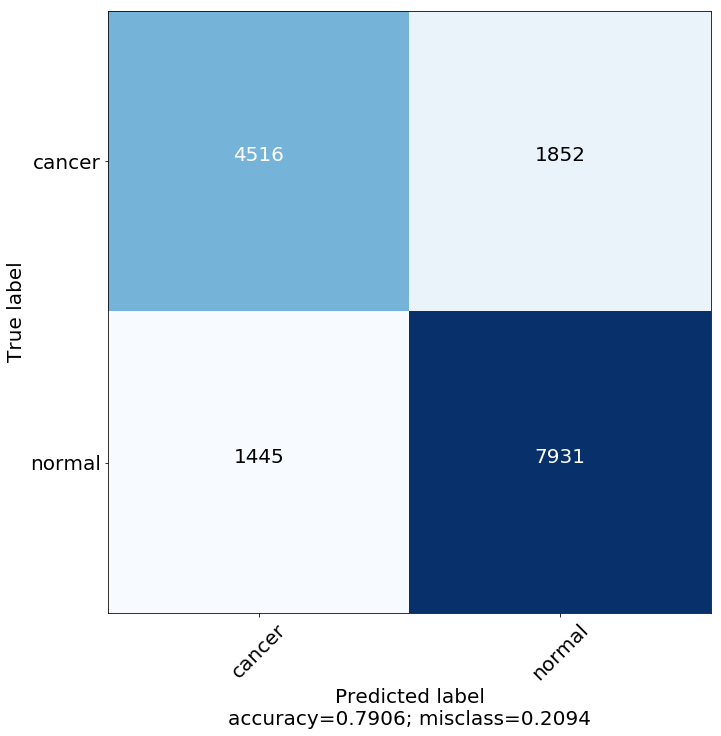

In [25]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[4516 1852]
 [1445 7931]]
             precision    recall  f1-score   support

     cancer       0.76      0.71      0.73      6368
     normal       0.81      0.85      0.83      9376

avg / total       0.79      0.79      0.79     15744



In [27]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  75.75910082200973
Specificity :  81.06920167637739


In [28]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.7841415124919355


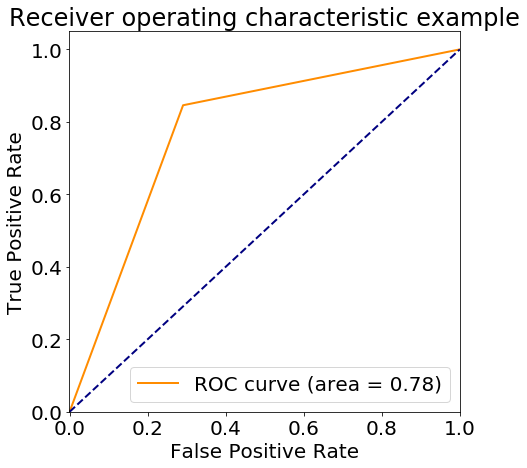

In [29]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [30]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

15744/15744 [==============================] - 0s 22us/step


In [31]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [32]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

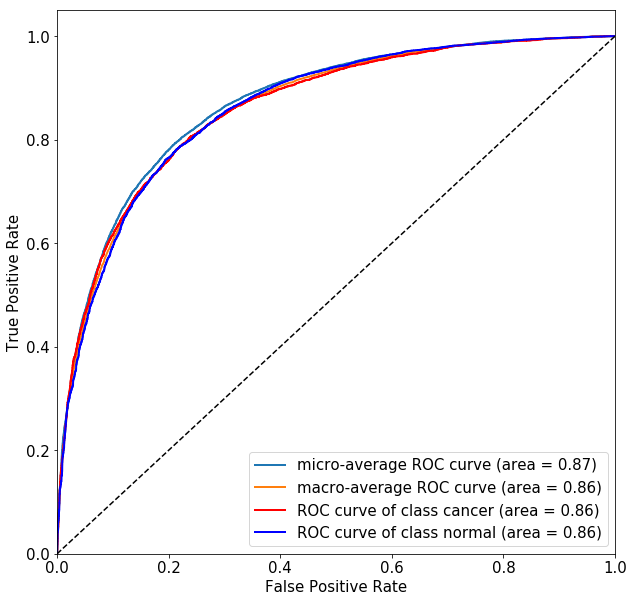

In [33]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [34]:
tn, fp, fn, tp = cm.ravel()

In [35]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.7905868902439024
Precision: 0.8106920167637739
Recall: 0.8458831058020477
tp: 7931
fp: 1852
tn: 4516
fn: 1445


In [36]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8279137742053343


In [37]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8279137742053343


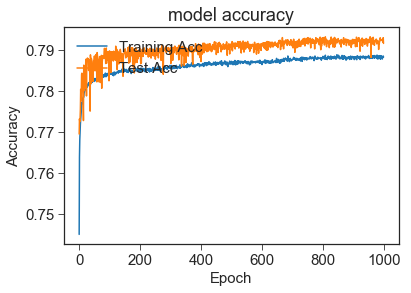

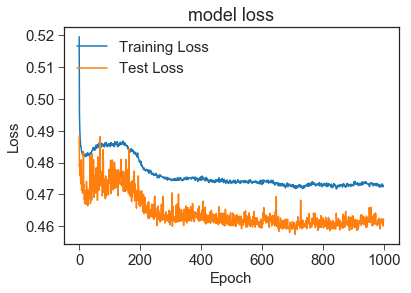

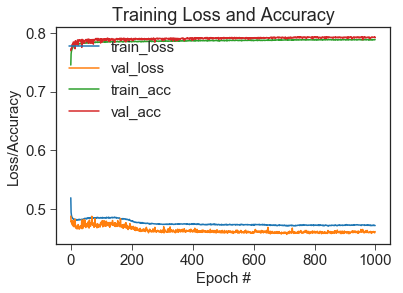

In [38]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")